# Reverse Engineering the UR3e IK parameters

Universal Robots posts the [DH parameters](https://www.universal-robots.com/articles/ur/application-installation/dh-parameters-for-calculations-of-kinematics-and-dynamics/) of all of their robots online, the hope is with these parameters for our robot, and the joint position read off the modbus, we might be able to reverse-engineering the inverse kinematics and write our own controller for working with a floating coordinate system.

In [38]:
import numpy as np
import json
import os
import time
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

%load_ext autoreload
%autoreload 2
%matplotlib inline

# print(plt.style.available)
plt.style.use('dark_background')
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
DH = np.array([[0, 0, 0.1519,np.pi/2],
                    [0,-0.2434,0.,0.],
                    [0,-0.2132,0.,0.],
                    [0,0.,0.1311,np.pi/2],
                    [0,0.,0.0854,-np.pi/2],
                    [0,0.,0.0921,0.]])

print("Available files:")
files = []
for file in os.listdir():
    if file.endswith(".json"):
        # print("\t" + file)
        files.append(file)

i = 8

path = os.path.abspath("..\\IK_Scans") + "\\" + files[i]

print(path)

with open(path, 'r') as infile:
    json_data = json.load(infile)

if 'Notes' in json_data.keys():
    print(json_data['Notes'])

joints_at_points = json_data["joints_at_points"]

start_joints = joints_at_points[0][1]

print(np.rad2deg(start_joints))
names = ("Floating coordinate system", "Joint angles", "Base position")
for i in range(3):
    print(f"{names[i]}: {joints_at_points[0][i]}")
print(f"Number of points: {len(joints_at_points)}")

Available files:
c:\Users\ander\OneDrive - UW\Robotics lab material\Robotics Control Code\Ben's Control Code\IK_Scans\Test_08_11__15_06.json
This is the eigth test file, and it's pretty good, decent range of motion, worth studying.
[[ 166.6734]
 [ 307.7356]
 [ 94.8818]
 [ 228.2664]
 [ 273.6446]
 [ 107.3150]]
Floating coordinate system: [[0, 0, 0], [0, 0, 0]]
Joint angles: [[2.909], [5.371], [1.656], [3.984], [4.776], [1.873]]
Base position: [[[0.4106], [0.0533], [-0.0662]], [[-0.822], [-3.011], [-0.089]]]
Number of points: 33


In [40]:
a = np.array([[1,0,0],[0,0,-1],[0,1,0]])
np.trace(a)

1

In [95]:
#               theta,a,d,alpha     (radians and meters)
# Theta represents the current orientation of that particular joint
tcp_offset = 0.173 # Accurate to the programmed TCP offset
DH = np.array([[0, 0, 0.15185,np.pi/2],
                [0,-0.24335,0.,0.],
                [0,-0.2132,0.,0.],
                [0,0.,0.13105,np.pi/2],
                [0,0.,0.08535,-np.pi/2],
                [0,0.,0.0921,0.],
                [0,0,tcp_offset,0]])

def plot_linkages(points, target=None,color='viridis'):
    '''Accepts as input an (n,6) ndarray representing a series of n joint
    positions, with each (6,) subarray being in the form (X,Y,Z,beta,alpha,gamma)'''
    def set_axes_equal(ax):
        '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
        cubes as cubes, etc..  This is one possible solution to Matplotlib's
        ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

        Input
        ax: a matplotlib axis, e.g., as output from plt.gca().
        '''

        x_limits = ax.get_xlim3d()
        y_limits = ax.get_ylim3d()
        z_limits = ax.get_zlim3d()

        x_range = abs(x_limits[1] - x_limits[0])
        x_middle = np.mean(x_limits)
        y_range = abs(y_limits[1] - y_limits[0])
        y_middle = np.mean(y_limits)
        z_range = abs(z_limits[1] - z_limits[0])
        z_middle = np.mean(z_limits)

        # The plot bounding box is a sphere in the sense of the infinity
        # norm, hence I call half the max range the plot radius.
        plot_radius = 0.5*max([x_range, y_range, z_range])
        xlim,ylim,zlim = ([x_middle - plot_radius, x_middle + plot_radius],
                            [y_middle - plot_radius, y_middle + plot_radius],
                            [z_middle - plot_radius, z_middle + plot_radius])

        ax.set_xlim3d(xlim)
        ax.set_ylim3d(ylim)
        ax.set_zlim3d(zlim)
        # return ([x_middle - x_range/2,x_middle + x_range/2,],
        #         [y_middle - y_range/2,y_middle + y_range/2,],
        #         [z_middle - z_range/2,z_middle + z_range/2,])
        return (xlim,ylim,zlim)

    if len(points.shape) == 1:
        points = np.array([points])
    
    points = np.append(np.array([[0,0,0,0,0,0]]),points,axis=0)
    
    fig = plt.figure(figsize=(24,6))
    ax = fig.add_subplot(1,4,1,projection='3d')
    
    # ax.quiver(Xs,points[:,1],points[:,2],points[:,3],points[:,4],points[:,5], c='r')
    Xs,Ys,Zs = points[:,0],points[:,1],points[:,2]
    ax.plot3D(Xs,Ys,Zs, c='r')
    ax.scatter(Xs,Ys,Zs,alpha=1,c=range(points.shape[0]),
        cmap=color, s=100)
    if target is not None:
        ax.scatter(target[0],target[1],target[2],alpha=1,c='b',s=200)

    ax.set_title("3D view")
    x,y,z = np.zeros((3,3))
    u,v,w = np.eye(3)
    # w,v,u = np.ones((3,3)) - np.eye(3)
    ax.quiver(x,y,z,u,v,w,length=0.25,arrow_length_ratio=0.1)
    xlim,ylim,zlim = set_axes_equal(ax)

    arrow_scale = 5

    ax = fig.add_subplot(1,4,2)
    ax.plot(Xs,Ys,c='r')
    ax.scatter(Xs,Ys,alpha=1,c=range(points.shape[0]),
        cmap=color, s=100)
    ax.quiver(x,y,u,v,scale=arrow_scale,color='w')
    if target is not None:
        ax.scatter(target[0],target[1],alpha=1,c='b',s=200)
    ax.set_title("Top view")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax = fig.add_subplot(1,4,3)
    ax.plot(Ys,Zs,c='r')
    ax.scatter(Ys,Zs,alpha=1,c=range(points.shape[0]),
        cmap=color, s=100)
    ax.quiver(y,z,v,w,scale=arrow_scale,color='w')
    if target is not None:
        ax.scatter(target[1],target[2],alpha=1,c='b',s=200)
    ax.set_title("Front view")
    ax.set_xlim(ylim)
    ax.set_ylim(zlim)

    ax = fig.add_subplot(1,4,4)
    ax.plot(Xs,Zs,c='r')
    ax.scatter(Xs,Zs,alpha=1,c=range(points.shape[0]),
        cmap=color, s=100)
    ax.quiver(x,z,u,w,scale=arrow_scale,color='w')
    if target is not None:
        ax.scatter(target[0],target[2],alpha=1,c='b',s=200)
    ax.set_title("Side view")
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)

    plt.show()

def matrix_to_coordinates(mat):
    '''Accepts as input a 4x4 numpy array representing a transformation matrix
    and returns that transformation in an np array of the form
    [X,Y,Z, beta, alpha, gamma]'''
    X = mat[0,3]
    Y = mat[1,3]
    Z = mat[2,3]

    beta = np.arctan2((mat[0,0]**2 + mat[1,0]**2)**0.5,-mat[2,0])
    cosb=np.cos(beta)
    alpha = np.arctan2(mat[0,0]/cosb, mat[1,0]/cosb)
    gamma = np.arctan2(mat[2,2]/cosb, mat[2,1]/cosb)

    # r = mat[0:3,0:3]
    # print(r)
    # theta = np.arccos((np.trace(r) - 1)/2)
    # # print(theta)
    # temp = 1/(2*np.sin(theta))
    # # print(temp)

    # w = temp *np.array([[r[2,1] - r[1,2]],[r[0,2]-r[2,0]],[r[1,0]-r[0,1]]])
    # print(w)

    return np.array([X,Y,Z,beta,alpha,gamma])
    # return np.array([X,Y,Z,w[0],w[1],w[2]])

def joints_forward_kinematics_messy(joints,plot=False):
    '''Accepts as input a list of 6 joint positions in radians'''
    joints = np.array(joints).flatten()
    # joints = np.append(joints,0)
    DH_params = DH.copy()
    DH_params[:,0] = joints

    j_pos = []
    for i in range(6):
        theta,a,d,alpha = DH_params[i,:].tolist()
        
        trans_1 = np.eye(4)
        trans_1[2,3] = d

        rot_1 = np.array([[np.cos(theta), -np.sin(theta),0,0],
                        [np.sin(theta), np.cos(theta),0,0],
                        [0,0,1,0],
                        [0,0,0,1]])
        
        trans_2 = np.eye(4)
        trans_2[0,3] = a

        rot_2 = np.array([[1,0,0,0],
                        [0,np.cos(alpha), -np.sin(alpha),0],
                        [0,np.sin(alpha), np.cos(alpha),0],
                        [0,0,0,1]])
        j_pos.append(np.matmul(trans_1,
                        np.matmul(rot_1,
                        np.matmul(trans_2,rot_2))))
    
    links = np.zeros((6,6))
    t = j_pos[0]
    links[0] = matrix_to_coordinates(t)
    for i in range(5):
        t = np.matmul(t,j_pos[i+1])
        links[i+1] = matrix_to_coordinates(t)

    if plot:
        plot_linkages(links)

    return matrix_to_coordinates(t)

def joints_forward_kinematics(joints,debug=False):
    '''Accepts as input a list of 6 joint positions in radians, returns
    the point of the endpoint of the tool, in theory.'''
    joints = np.array(joints).flatten()
    # joints = np.append(joints,0)
    DH_params = DH.copy()
    DH_params[0:6,0] = joints

    j_pos = []
    for i in range(7):
        cos_io = np.cos(DH_params[i,0])
        sin_io = np.sin(DH_params[i,0])
        cos_i3 = np.cos(DH_params[i,3])
        sin_i3 = np.sin(DH_params[i,3])

        j_pos.append(np.array([
            [cos_io, -sin_io * cos_i3, sin_io * sin_i3, DH_params[i,1] * cos_io],
            [sin_io, cos_io * cos_i3, -cos_io * sin_i3, DH_params[i,1] * sin_io],
            [0., sin_i3, cos_i3,DH_params[i,2]],
            [0.,0.,0.,1.]
            ]))
    
    # (T1,T2,T3,T4,T5,T6) = tuple(j_pos)
    # t = T1
    if debug:
        [print(f"{j}\n--------------") for j in tuple(j_pos)]

    links = np.zeros((7,6))
    t = j_pos[0]
    if debug:
        print(t)
    links[0] = matrix_to_coordinates(t)
    for i in range(6):
        t = np.matmul(t,j_pos[i+1])
        if debug:
            print(t)
        links[i+1] = matrix_to_coordinates(t)

    return links


Start position: [ 0.4108  0.0547 -0.0659  1.6044  2.1051  1.6269]
Joint angles: [[ 157.7926  320.6845  78.1514  245.7989  290.2604  95.7412]]
Endpoint: [ 0.4306  0.0649 -0.0899  1.8597  2.0565  1.8980]


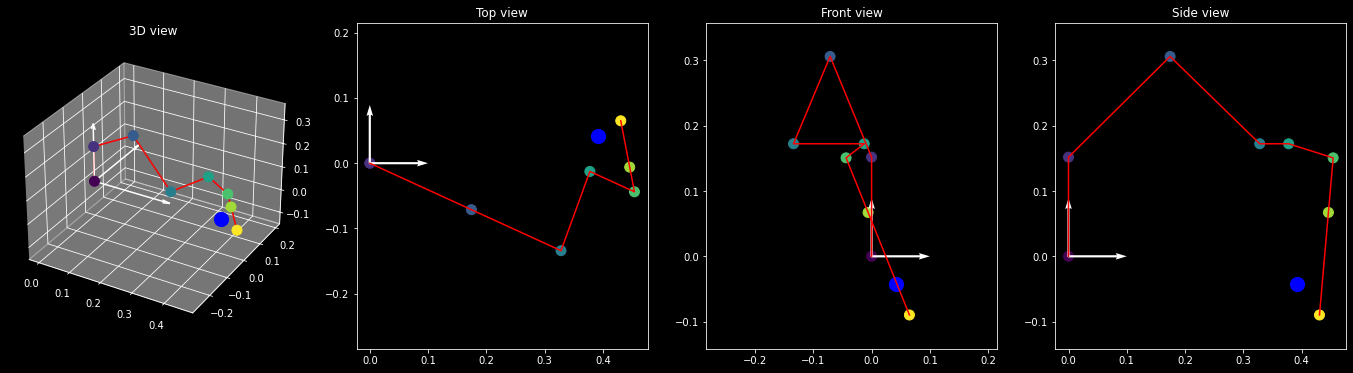

In [96]:
index = 13

joints = joints_at_points[index][1]
base_pos = joints_at_points[index][2]
base_pos = np.array(base_pos).flatten()
floating_pos = joints_at_points[index][0]

# ("Floating coordinate system", "Joint angles", "Base position")
# error = []
links = joints_forward_kinematics(joints_at_points[0][1])
start_position = links[-1]
# print(f"Start position: {start_position}")

print(f"Joint angles: {np.rad2deg(joints).T}")
links = joints_forward_kinematics(joints,debug=False)
print(f"Endpoint: {links[-1]}")
print(f"Target: {base_pos}")

plot_linkages(links,base_pos)

In [93]:
l = 32
stepwise = False
errors = np.zeros((l+1,6))

for i in range(l):
    joints = joints_at_points[i][1]
    base_pos = joints_at_points[i][2]
    base_pos = np.array(base_pos).flatten()
    floating_pos = np.array(joints_at_points[i][0]).flatten() * 0.001

    # ("Floating coordinate system", "Joint angles", "Base position")
    actual_joints = np.array(joints).flatten()

    links = joints_forward_kinematics(joints)
    calc = links[-1]
    # print(calc)
    # print(base_pos)
    if stepwise:
        # print(f"Starting position:\t\t{start_position}")
        print(f"Current position:\t\t\t{base_pos[0:3]}")
        # print(f"Current joint angles:\t\t{actual_joints}")
        print(f"Calculated current position:\t\t{calc[0:3]}")
        print(f"Error:\t\t\t\t\t{calc[0:3] - base_pos[0:3]}")
        print(f"Normalized translational change, actual: {np.sum((base_pos-start_position)[0:3]**2)**0.5}")
        print(f"Normalized translational change, calculated: {np.sum((calc-start_position)[0:3]**2)**0.5}")
        print(f"Pos in floating coordinate system:\t{floating_pos[0:3]}")
        print(f"Normalized translational change, floating: {np.sum(floating_pos[0:3]**2)**0.5}")
        print("---------------------")
    errors[i] = calc-base_pos
    # print(f"Non-dimensional error {np.sum((calc-base_pos)[0:3]**2)**0.5}")

print(f"Average error: {np.average(errors,axis=0) * 1000}(mm)")
print(errors[:,0:3] * 1000)


Average error: [-0.6059  0.7739 -0.6111  1395.6791 -117.8742 -193.6854](mm)
[[ 0.1538  1.3955  0.2950]
 [-9.3446 -13.2071 -25.9990]
 [-10.3987  7.0643  0.2938]
 [ 38.3760  19.7416  0.9457]
 [-17.6047 -29.6293 -1.0657]
 [-1.8206  44.0271  3.2389]
 [ 2.2108 -44.4520  47.5076]
 [ 17.7987  32.3456  1.9885]
 [-17.8143 -27.7502 -51.5093]
 [-2.6337  41.6840  52.4744]
 [-18.2355 -26.2904 -51.1535]
 [-0.1987  1.0643 -0.0062]
 [ 0.6966 -2.3327  49.9828]
 [ 39.3684  22.5292 -48.0552]
 [-39.2336 -20.4978  48.4444]
 [-0.4336  1.2022 -0.4556]
 [ 20.0549 -8.2237 -50.7312]
 [ 18.7092  28.5391  52.0581]
 [-0.5240  4.0416 -49.9543]
 [-20.0074  13.4495  1.5284]
 [-18.5987 -29.8357 -1.9062]
 [ 17.8911  31.5217  1.5663]
 [ 2.1003 -41.3442 -2.4549]
 [ 0.8650 -2.7135  50.4677]
 [-20.6698  13.6106  1.2199]
 [ 38.4236  23.3083 -48.5130]
 [ 0.4092 -2.2609  50.1581]
 [-18.6693 -29.7951 -2.1530]
 [ 18.0904  31.8531  1.8351]
 [-0.5764  4.5083 -49.5130]
 [-20.3085  9.9772  50.9432]
 [-18.0707 -27.9923 -51.6448]
 [ 

In [44]:
print(DH)
theta,d,a,alpha = DH[2,:].tolist()
print(d)

[[ 0.0000  0.0000  0.1519  1.5708]
 [ 0.0000 -0.2434  0.0000  0.0000]
 [ 0.0000 -0.2132  0.0000  0.0000]
 [ 0.0000  0.0000  0.1310  1.5708]
 [ 0.0000  0.0000  0.0853 -1.5708]
 [ 0.0000  0.0000  0.0921  0.0000]
 [ 0.0000  0.0000  0.1730  0.0000]]
-0.2132


In [45]:
(x0,x1) = (0,0)
(y0,y1) = (0,0)
(z0,z1) = (-9,9)
(Rx0,Rx1) = (-14,14)
(Ry0,Ry1) = (-14,14)
(Rz0,Rz1) = (0,0)

res=(1,2)

X,Y,Z,Rx,Ry,Rz = np.mgrid[
            x0:x1:(int((x1-x0)/res[0])+1)*1j,
            y0:y1:(int((y1-y0)/res[0])+1)*1j,
            z0:z1:(int((z1-z0)/res[0])+1)*1j,
            Rx0:Rx1:(int((Rx1-Rx0)/res[1])+1)*1j,
            Ry0:Ry1:(int((Ry1-x0)/res[1])+1)*1j,
            Rz0:Rz1:(int((Rz1-x0)/res[1])+1)*1j]
all_points = np.vstack((X.flatten(),Y.flatten(),Z.flatten(),
        Rx.flatten(),Ry.flatten(),Rz.flatten())).T

print(all_points[0:5])

[[ 0.0000  0.0000 -9.0000 -14.0000 -14.0000  0.0000]
 [ 0.0000  0.0000 -9.0000 -14.0000 -10.0000  0.0000]
 [ 0.0000  0.0000 -9.0000 -14.0000 -6.0000  0.0000]
 [ 0.0000  0.0000 -9.0000 -14.0000 -2.0000  0.0000]
 [ 0.0000  0.0000 -9.0000 -14.0000  2.0000  0.0000]]


In [46]:
links = np.eye(6)
print(links)
print(links[:,1])

[[ 1.0000  0.0000  0.0000  0.0000  0.0000  0.0000]
 [ 0.0000  1.0000  0.0000  0.0000  0.0000  0.0000]
 [ 0.0000  0.0000  1.0000  0.0000  0.0000  0.0000]
 [ 0.0000  0.0000  0.0000  1.0000  0.0000  0.0000]
 [ 0.0000  0.0000  0.0000  0.0000  1.0000  0.0000]
 [ 0.0000  0.0000  0.0000  0.0000  0.0000  1.0000]]
[ 0.0000  1.0000  0.0000  0.0000  0.0000  0.0000]
